In [ ]:
!pip install roboflow

from roboflow import Roboflow
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd


  Using cached roboflow-1.1.36-py3-none-any.whl (76 kB)
  Using cached chardet-4.0.0-py2.py3-none-any.whl (178 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl (19 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl (54 kB)
  Using cached filetype-1.2.0-py2.py3-none-any.whl (19 kB)
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="zFQnSt2437Ig6aCAtSZ4", model_format="clip")
dataset = rf.workspace("yulia-pratiwi-45vut").project("derma").version(1).download(location="/content/Dermalysis")



loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /content/Dermalysis in clip:: 100%|██████████| 3495/3495 [00:01<00:00, 2117.00it/s]


In [ ]:
from pathlib import Path
image_dir = Path('/content/Dermalysis/train')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
import pandas as pd
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(4)

Filepath      Label
0  /content/Dermalysis/train/Kurap/aug_0_Screensh...      Kurap
1  /content/Dermalysis/train/KutuAir/images-6-_jp...    KutuAir
2  /content/Dermalysis/train/KutuAir/FU-athlete-f...    KutuAir
3  /content/Dermalysis/train/JamurKuku/173_jpg.rf...  JamurKuku

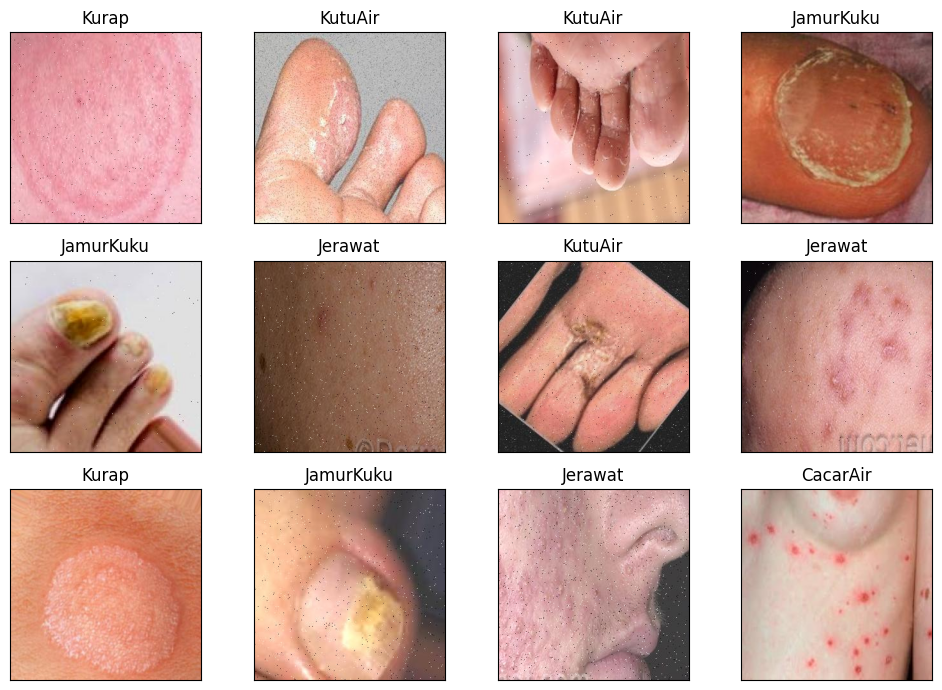

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



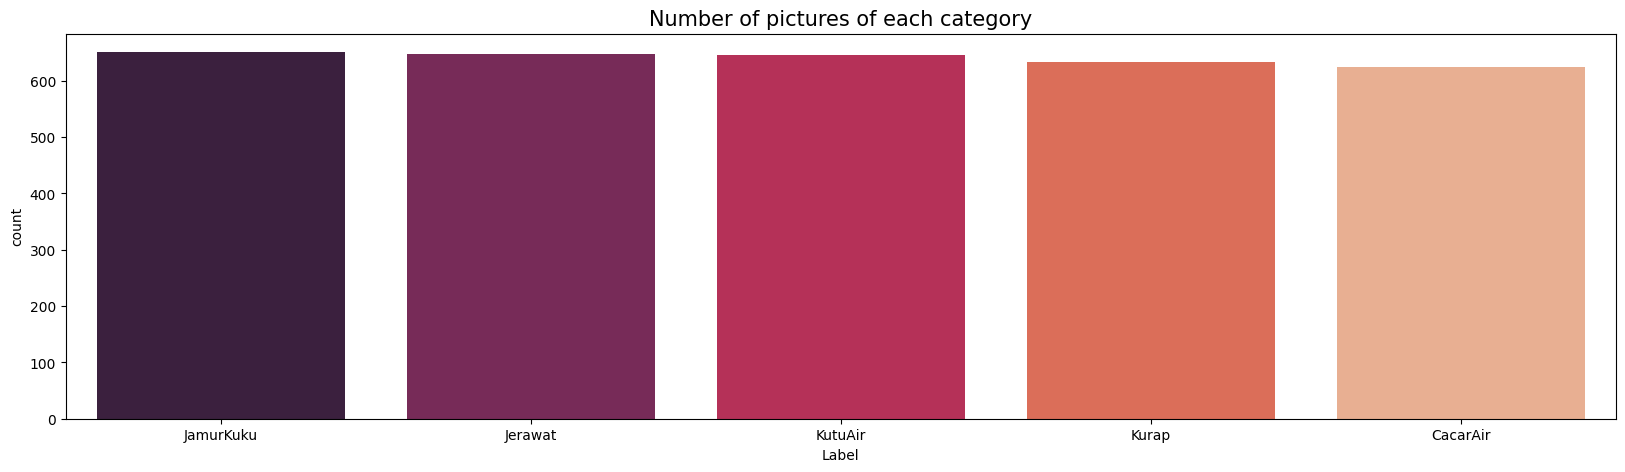

In [ ]:
import seaborn as sns
vc = image_df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [ ]:
#Shuffle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# Separate in train and test data
train_df, validasi_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

In [ ]:
#data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_dataframe(dataframe=train_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                         seed=0,
                                         target_size=(416,416),
                                         batch_size=32,
                                         shuffle=True,
                                         class_mode = 'categorical',
                                        subset='training',
                                         )

validasi_data = val_datagen.flow_from_dataframe(dataframe=validasi_df,
                                        x_col='Filepath',
                                        y_col='Label',
                                         seed=0,
                                         target_size=(416,416),
                                         batch_size=32,
                                         shuffle=False,
                                         class_mode = 'categorical',
                                         )

Found 2560 validated image filenames belonging to 5 classes.
Found 641 validated image filenames belonging to 5 classes.


In [ ]:
from keras import Model, Input
input_shape = (416,416,3)
model_input = Input(shape=input_shape)

In [ ]:
from keras.applications.densenet import DenseNet201
from keras import layers
from keras import Model, Input
from tensorflow.keras.optimizers import RMSprop

from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import torchvision.models as models
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
denseNet = DenseNet201(input_shape=input_shape, input_tensor=model_input, include_top=False, weights="imagenet")

74836368/74836368 [==============================] - 1s 0us/step


In [ ]:
for layer in denseNet.layers:
    layer.trainable = False

In [ ]:
denseNet_last_output = denseNet.get_layer('relu').output

# Print informasi tentang output layer terakhir
print('Last layer output shape:', denseNet_last_output.shape)

Last layer output shape: (None, 13, 13, 1920)


In [ ]:
# Flatten the output layer to 1 dimension
x_denseNet = layers.GlobalMaxPooling2D()(denseNet_last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x_denseNet = layers.Dense(512, activation='relu')(x_denseNet)
# Add a dropout rate of 0.7
x_denseNet = layers.Dropout(0.15)(x_denseNet)
# Add a final sigmoid layer for classification
x_denseNet = layers.Dense(5, activation='softmax')(x_denseNet)

# Configure and compile the model

denseNet_model = Model(model_input, x_denseNet)
optimizer = RMSprop(learning_rate=0.0001)
denseNet_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
denseNet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 422, 422, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 208, 208, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 208, 208, 64)         256       ['conv1/conv[0][0]']      

In [ ]:
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('loss') < 0.05 and logs.get('val_accuracy') > 0.90:
            print("\nStop, Akurasi mencapai 98%")
            self.model.stop_training = True

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metrik yang ingin dipantau
    patience=5,          # Jumlah epoch tanpa peningkatan yang signifikan sebelum pelatihan dihentikan
    verbose=1,           # Menampilkan pesan ketika pelatihan dihentikan
    restore_best_weights=True # Mengembalikan bobot terbaik saat pelatihan dihentikan
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Tentukan path penyimpanan model
# Tentukan path penyimpanan model dengan ekstensi .keras
checkpoint_path = '/content/drive/MyDrive/Percobaan-Desnet201/Desnet201.h5'


# Buat callback ModelCheckpoint
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_loss',  # Metrik yang akan dipantau
                                      save_best_only=True,  # Hanya menyimpan model terbaik
                                      save_weights_only=False,  # Menyimpan seluruh model
                                      mode='min',  # Mode pemantauan (misalnya, 'min', 'max', atau 'auto')
                                      verbose=1)  # Menampilkan pesan saat menyimpan


In [ ]:
from tensorflow.keras.optimizers import Adam
# Set the training parameters
callbacks = [myCallback(), early_stopping]
denseNet_model.compile(optimizer = Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
history_denseNet = denseNet_model.fit(
                  train_data,
                  validation_data=validasi_data,
                  steps_per_epoch=train_data.n/32,
                  validation_steps=validasi_data.n/32,
                  epochs=25,
                  callbacks=([callbacks],[checkpoint_callback]))

Epoch 1/25
80/80 [==============================] - ETA: 0s - loss: 1.5100 - accuracy: 0.5051
Epoch 1: val_loss improved from inf to 0.99692, saving model to /content/drive/MyDrive/Percobaan-Desnet201/Desnet201.h5


You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


80/80 [==============================] - 209s 2s/step - loss: 1.5100 - accuracy: 0.5051 - val_loss: 0.9969 - val_accuracy: 0.6474
Epoch 2/25
80/80 [==============================] - ETA: 0s - loss: 0.8676 - accuracy: 0.6938
Epoch 2: val_loss improved from 0.99692 to 0.65439, saving model to /content/drive/MyDrive/Percobaan-Desnet201/Desnet201.h5
80/80 [==============================] - 151s 2s/step - loss: 0.8676 - accuracy: 0.6938 - val_loss: 0.6544 - val_accuracy: 0.7410
Epoch 3/25
80/80 [==============================] - ETA: 0s - loss: 0.7050 - accuracy: 0.7402
Epoch 3: val_loss improved from 0.65439 to 0.58871, saving model to /content/drive/MyDrive/Percobaan-Desnet201/Desnet201.h5
80/80 [==============================] - 150s 2s/step - loss: 0.7050 - accuracy: 0.7402 - val_loss: 0.5887 - val_accuracy: 0.7644
Epoch 4/25
80/80 [==============================] - ETA: 0s - loss: 0.6033 - accuracy: 0.7879
Epoch 4: val_loss improved from 0.58871 to 0.51555, saving model to /content/dri

In [ ]:
MODEL_BASE_PATH = "/content/drive/MyDrive"
PROJECT_NAME = "Percobaan-Densenet201"
SAVE_MODEL_NAME = "Densenet201.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

print('Saving Model At {}...'.format(save_model_path))
denseNet_model.save(save_model_path,include_optimizer=False)

Saving Model At /content/drive/MyDrive/Percobaan-Densenet201/Densenet201.h5...


In [ ]:
#plotting
import matplotlib.pyplot as plt
def display_training_curves(training, validation, title, subplot):

    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


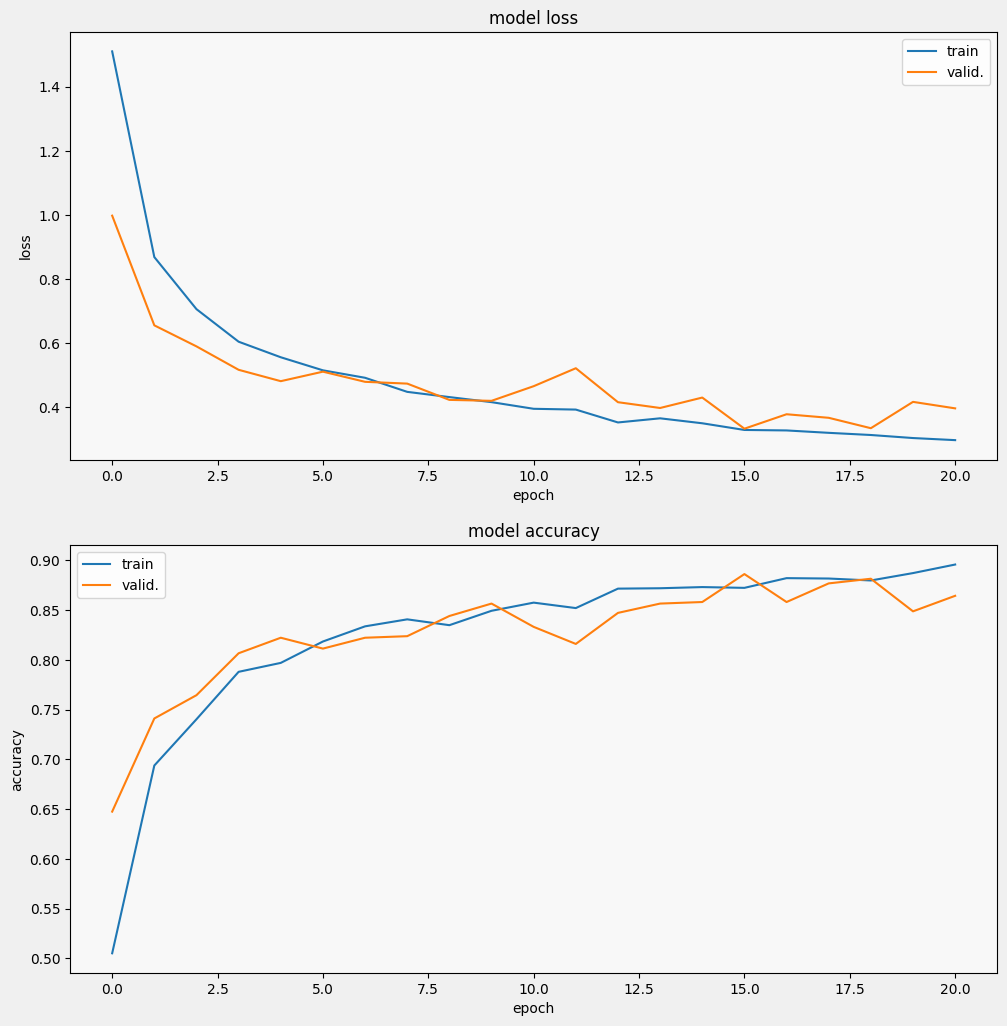

In [ ]:
#display
display_training_curves(
    history_denseNet.history['loss'],
    history_denseNet.history['val_loss'],
    'loss', 211)
display_training_curves(
    history_denseNet.history['accuracy'],
    history_denseNet.history['val_accuracy'],
    'accuracy', 212)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Tentukan path ke data uji
test_data_path = "/content/Dermalysis/test"

# Buat instance ImageDataGenerator untuk data uji
test_datagen = ImageDataGenerator(rescale=1./255)

# Buat generator data uji
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(416, 416),  # Ukuran gambar yang sama dengan data pelatihan
    batch_size=16,
    class_mode=None,
    shuffle=False
)

# Prediksi label gambar uji
pred = denseNet_model.predict(test_generator)
pred = np.argmax(pred, axis=1)

# Peta indeks label ke nama kelas
labels = (train_data.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred_labels = [labels[k] for k in pred]

# Mendapatkan label asli dari data uji
true_labels = test_generator.classes
true_labels = [labels[k] for k in true_labels]


# Laporan Klasifikasi
print(classification_report(true_labels, pred_labels))



Found 278 images belonging to 5 classes.
18/18 [==============================] - 25s 692ms/step
              precision    recall  f1-score   support

    CacarAir       0.88      0.92      0.90        61
   JamurKuku       1.00      0.88      0.94        52
     Jerawat       0.94      0.89      0.91        53
       Kurap       0.83      0.83      0.83        58
     KutuAir       0.87      0.96      0.91        54

    accuracy                           0.90       278
   macro avg       0.90      0.90      0.90       278
weighted avg       0.90      0.90      0.90       278



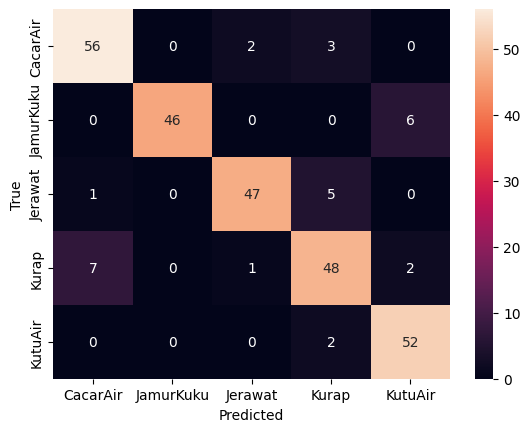

In [ ]:
# Matriks
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels.values(), yticklabels=labels.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

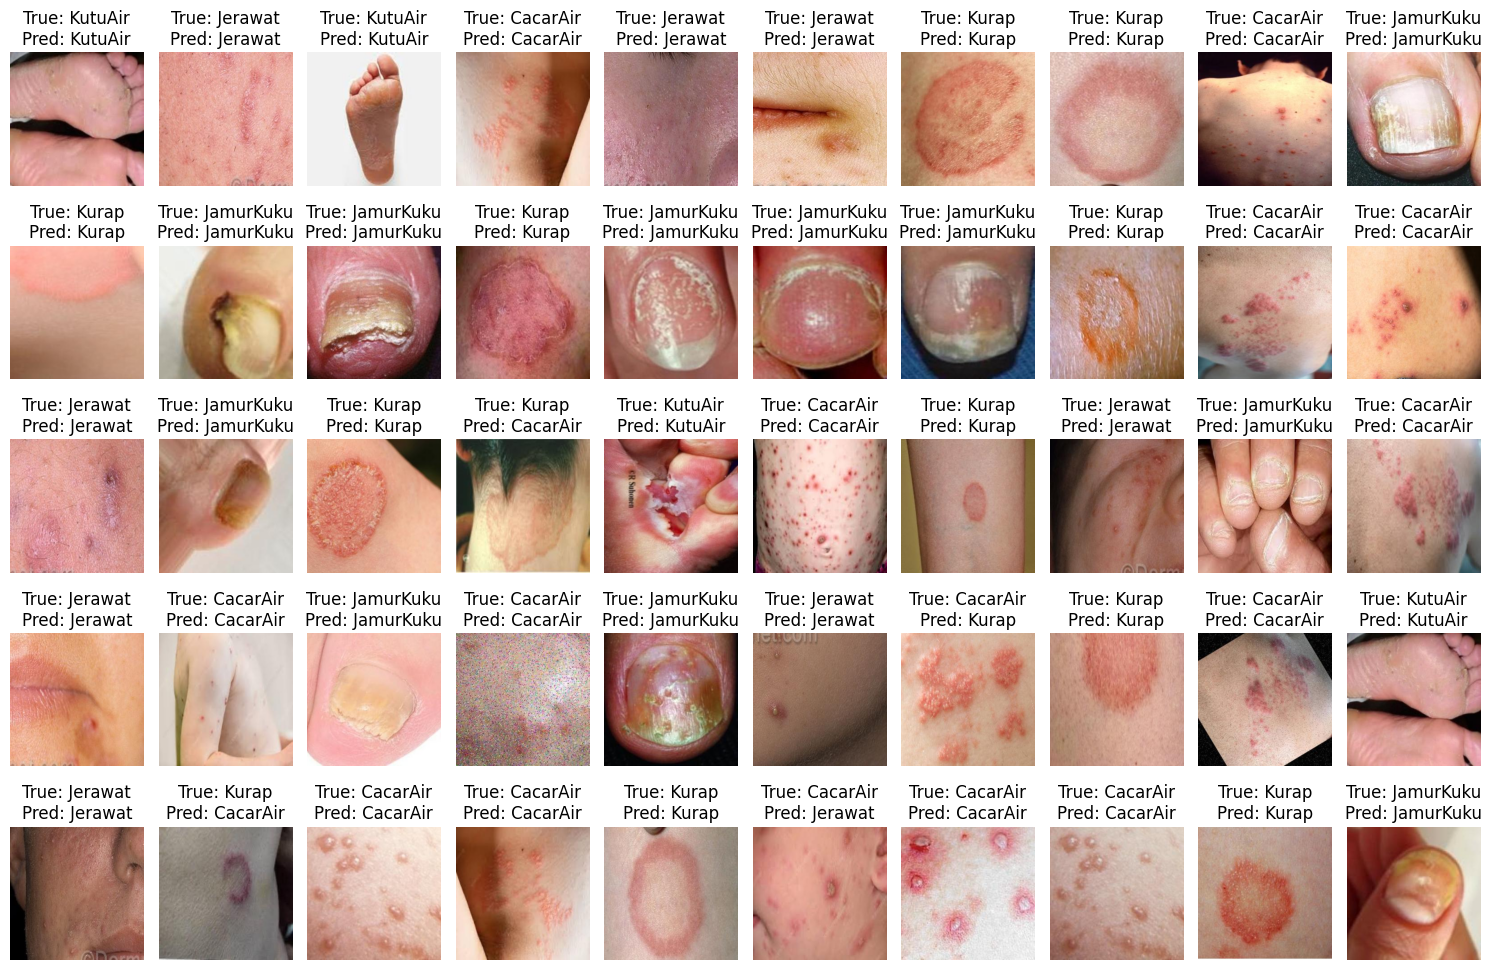

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ambil beberapa contoh gambar dan prediksinya
num_rows = 5
num_cols = 10
num_images = num_rows * num_cols

indices = np.random.choice(len(pred_labels), num_images, replace=False)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for i, idx in enumerate(indices):
    row = i // num_cols
    col = i % num_cols

    img_path = test_generator.filepaths[idx]
    img = plt.imread(img_path)
    true_label = true_labels[idx]
    pred_label = pred_labels[idx]

    axes[row, col].imshow(img)
    axes[row, col].set_title(f'True: {true_label}\nPred: {pred_label}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Verifying the file path and listing files in the directory...
Densenet201.h5
Loading Model From /content/drive/MyDrive/Percobaan-Densenet201/Densenet201.h5...


Saving cacar air 9.jpeg to cacar air 9.jpeg
1/1 [==============================] - 4s 4s/step


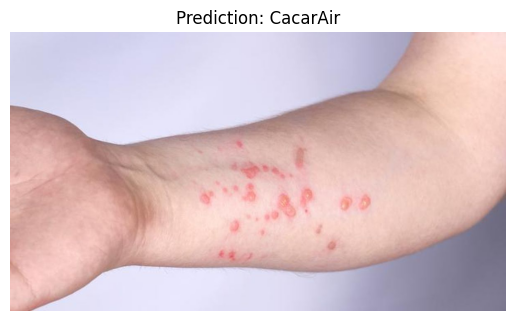

Prediction probabilities for each class:
CacarAir: 97.14%
JamurKuku: 0.00%
Jerawat: 0.83%
Kurap: 1.87%
KutuAir: 0.16%
Do you want to upload another image? (yes/no): yes


Saving jamur-kuku-doktersehat-1.jpg to jamur-kuku-doktersehat-1.jpg
1/1 [==============================] - 0s 49ms/step


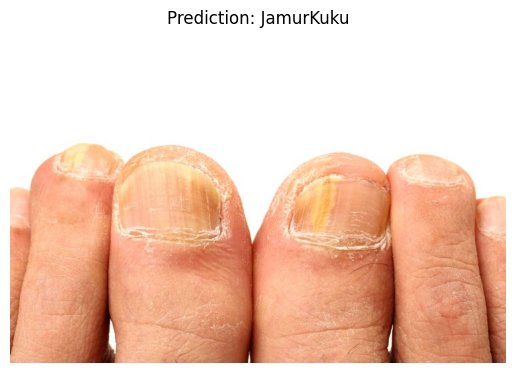

Prediction probabilities for each class:
CacarAir: 0.00%
JamurKuku: 80.52%
Jerawat: 0.01%
Kurap: 0.01%
KutuAir: 19.46%
Do you want to upload another image? (yes/no): yes


Saving kenalan-dengan-jerawat-meradang-dan-cara-mengatasinya_20220923071237.jpg to kenalan-dengan-jerawat-meradang-dan-cara-mengatasinya_20220923071237.jpg
1/1 [==============================] - 0s 35ms/step


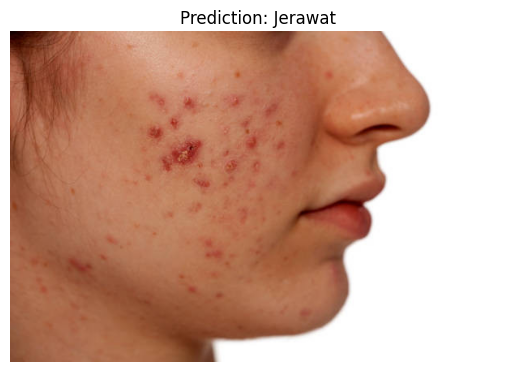

Prediction probabilities for each class:
CacarAir: 25.15%
JamurKuku: 0.00%
Jerawat: 73.79%
Kurap: 1.06%
KutuAir: 0.00%
Do you want to upload another image? (yes/no): yes


Saving kurap-di-wajahjpg-20230116012929.jpg to kurap-di-wajahjpg-20230116012929.jpg
1/1 [==============================] - 0s 34ms/step


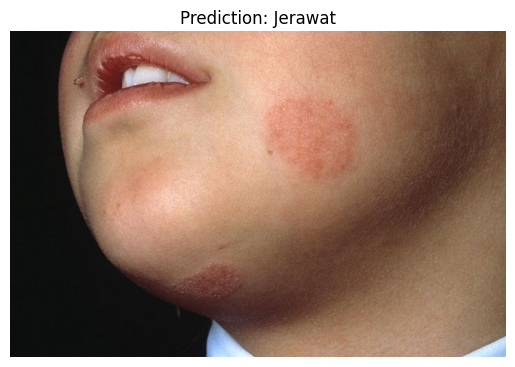

Prediction probabilities for each class:
CacarAir: 41.75%
JamurKuku: 0.00%
Jerawat: 45.62%
Kurap: 12.64%
KutuAir: 0.00%
Do you want to upload another image? (yes/no): yes


Saving images (7).jpeg to images (7).jpeg
1/1 [==============================] - 0s 54ms/step


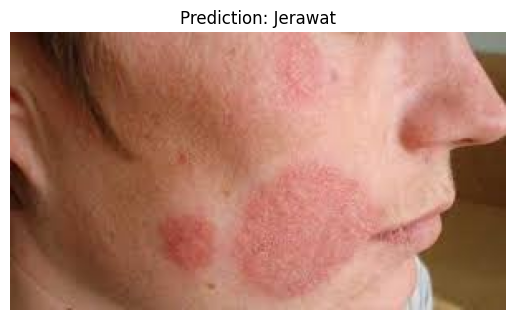

Prediction probabilities for each class:
CacarAir: 7.40%
JamurKuku: 2.38%
Jerawat: 79.45%
Kurap: 4.39%
KutuAir: 6.37%
Do you want to upload another image? (yes/no): yes


Saving images (3).jpeg to images (3).jpeg
1/1 [==============================] - 0s 38ms/step


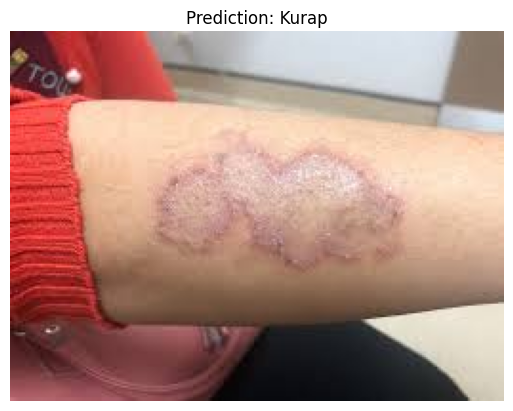

Prediction probabilities for each class:
CacarAir: 2.08%
JamurKuku: 0.08%
Jerawat: 0.01%
Kurap: 97.46%
KutuAir: 0.38%
Do you want to upload another image? (yes/no): yes


Saving 23-6-_jpeg.rf.514145721f7ba3a8693f1459eee6d369.jpg to 23-6-_jpeg.rf.514145721f7ba3a8693f1459eee6d369.jpg
1/1 [==============================] - 0s 45ms/step


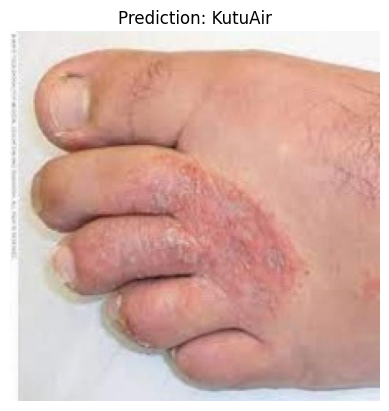

Prediction probabilities for each class:
CacarAir: 0.02%
JamurKuku: 0.81%
Jerawat: 0.01%
Kurap: 3.41%
KutuAir: 95.76%
Do you want to upload another image? (yes/no): yes


Saving Screenshot 2024-01-06 092238.png to Screenshot 2024-01-06 092238.png
1/1 [==============================] - 0s 36ms/step


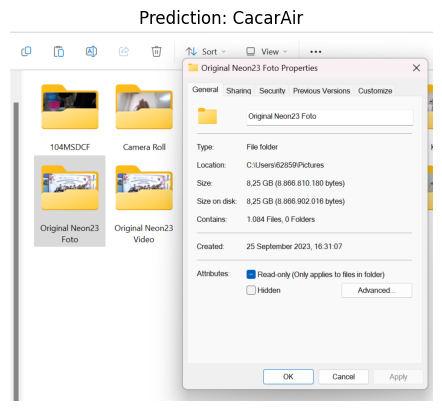

Prediction probabilities for each class:
CacarAir: 50.46%
JamurKuku: 2.16%
Jerawat: 1.15%
Kurap: 45.91%
KutuAir: 0.32%
Do you want to upload another image? (yes/no): yes


Saving Screenshot 2024-01-17 210440.png to Screenshot 2024-01-17 210440.png
1/1 [==============================] - 0s 57ms/step


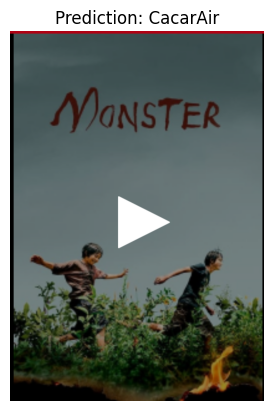

Prediction probabilities for each class:
CacarAir: 51.61%
JamurKuku: 0.01%
Jerawat: 1.41%
Kurap: 33.83%
KutuAir: 13.13%
Do you want to upload another image? (yes/no): no


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Verify the file path and list files in the directory
MODEL_BASE_PATH = "/content/drive/MyDrive"
PROJECT_NAME = "Percobaan-Densenet201"
SAVE_MODEL_NAME = "Densenet201.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)

print('Verifying the file path and listing files in the directory...')
!ls /content/drive/MyDrive/Percobaan-Densenet201/

# Load the model
if os.path.exists(save_model_path):
    print('Loading Model From {}...'.format(save_model_path))
    model = load_model(save_model_path)
else:
    print('Model file not found. Please check the path and filename.')
    model = None

# Function to load and process image
def load_and_process_image(image_path, target_size=(416, 416)):
    img = load_img(image_path, target_size=target_size)  # Resize image
    img_array = img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize image
    return img_array

# Make prediction if model is loaded
if model:
    while True:
        # Upload image
        uploaded = files.upload()
        for filename in uploaded.keys():
            image_path = filename

        # Process uploaded image
        img_array = load_and_process_image(image_path)

        # Make prediction
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)

        # Display prediction result
        class_labels = ['CacarAir', 'JamurKuku', 'Jerawat', 'Kurap', 'KutuAir']
        predicted_label = class_labels[predicted_class[0]]

        # Display image and prediction
        plt.imshow(Image.open(image_path))
        plt.title('Prediction: {}'.format(predicted_label))
        plt.axis('off')
        plt.show()

        # Display prediction probabilities
        print("Prediction probabilities for each class:")
        for i, label in enumerate(class_labels):
            print("{}: {:.2f}%".format(label, predictions[0][i] * 100))

        # Ask the user if they want to upload another image
        repeat = input("Do you want to upload another image? (yes/no): ").strip().lower()
        if repeat != 'yes':
            break
else:
    print('Cannot make predictions as the model is not loaded.')
